In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from src import Helpers

In [2]:
#Load all the notebooks

summary_df = Helpers.load_data("plot_summaries.txt")
movie_df = Helpers.load_data("movie.metadata.tsv")
character_df = Helpers.load_data("character.metadata.tsv")
char_cluster_df = Helpers.load_data("name.clusters.txt")
tvtropes_df = Helpers.load_data("tvtropes.clusters.txt")

## Preliminary graphs on new actors across the year
We will extrapolate for each movie in an actor's career it's number in terms of major roles and overall roles where the actor played.


In [3]:
#For the major roles:
# Sort the DataFrame by 'Fb_actor_id', 'Actor_age', and 'Character'
character_df = character_df.sort_values(['Fb_actor_id', 'Actor_age', 'Character'])

# Create a mask to identify the major roles (Character is not NaN)
major_role_mask = character_df['Character'].notna()

# Calculate the i-th film for each actor based on major roles and/without minor roles

character_df['Num_Roles'] = character_df.groupby(character_df['Fb_actor_id']).cumcount()+1 

character_df['Num_Major_Roles'] = (major_role_mask.groupby(character_df['Fb_actor_id']).cumsum()
                    .where(major_role_mask, np.nan))  # Set 0 for minor roles

#Display Jonnhy Depp table
jonnhy_depp = character_df[character_df['Actor_name']== "Johnny Depp"]
jonnhy_depp.head(6)

,Wiki_movie_id,Fb_movie_id,release_date,Character,Actor date of birth,Actor gender,Actor_height,Fb_actor_ethnicity_id,Actor_name,Actor_age,Freebase character/actor map ID,Fb_char_id,Fb_actor_id,Num_Roles,Num_Major_Roles
120977,3028191,08ll52,1984.0,Glen Lantz,1963-06-09,M,1.78,01qhm_,Johnny Depp,21.0,0jsvh6,0csqbm,0jfx1,1.0,1.0
351263,3514297,09hq9g,1985.0,Jack,1963-06-09,M,1.78,01qhm_,Johnny Depp,21.0,03lfl4k,04fll8n,0jfx1,2.0,2.0
22381,19315787,04lgx5r,1986.0,Donnie Fleischer,1963-06-09,M,1.78,01qhm_,Johnny Depp,23.0,04q4cj_,0gxq38m,0jfx1,3.0,3.0
229949,113460,0sxmx,1986.0,Gator Lerner,1963-06-09,M,1.78,01qhm_,Johnny Depp,23.0,0k1yz8,02nwky0,0jfx1,4.0,4.0
441458,6614818,0gdv4x,1989.0,NaN,1963-06-09,M,1.78,01qhm_,Johnny Depp,25.0,0h9hhm2,NaN,0jfx1,5.0,NaN
85506,1452377,052q5y,1990.0,Cry-Baby Wade Walker,1963-06-09,M,1.78,01qhm_,Johnny Depp,26.0,0jwvr7,04fllfp,0jfx1,6.0,5.0


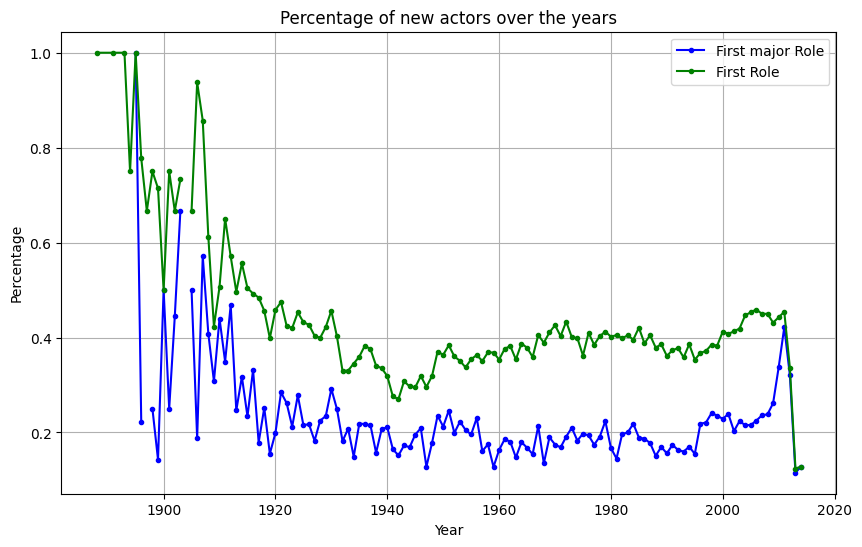

In [4]:
# Filter major roles (Character is not NaN)
major_roles = character_df[character_df['Character'] != 'NaN']

# Group by release date and calculate the number of actors with Film_Index equal to 1 or higher
major_actors_by_year = major_roles.groupby('release_date')['Fb_actor_id'].nunique()

# Group by release date and calculate the number of actors with Film_Index equal to 1 or higher
actors_by_year = character_df.groupby('release_date')['Fb_actor_id'].nunique()

# Group by release date and calculate the number of actors with Film_Index equal to 1
first_major_role_by_year = character_df[character_df['Num_Major_Roles'] == 1].groupby('release_date')['Fb_actor_id'].nunique()
first_role_by_year = character_df[character_df['Num_Roles'] == 1].groupby('release_date')['Fb_actor_id'].nunique()

# Calculate the ratio of actors with Film_Index 1 to actors with Film_Index 1 or higher for each year
major_ratio = first_major_role_by_year / major_actors_by_year
minor_ratio = first_role_by_year / actors_by_year

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(major_ratio.index, major_ratio, marker='.', linestyle='-', color='b', label= 'First major Role')
plt.plot(minor_ratio.index, minor_ratio, marker='.', linestyle='-', color='g', label= 'First Role')
plt.title('Percentage of new actors over the years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()

Add some comments about the first years and the last ones...

## Now we will add try to plot the transition matrix from the character_type to know how actors change their roles across  the year.


In [5]:
# Perform an outer merge to retain all rows from tvtropes
merged_data = character_df.merge(tvtropes_df, left_on=['Freebase character/actor map ID', 'Character'], right_on=['Fb_char_actor_id', 'Char'], how='outer')

# Keep only the specified columns
merged_data = merged_data[['Wiki_movie_id','release_date','Num_Major_Roles','CharType','Fb_actor_id']]

# Drop rows with NaN values in the 'CharType' column
merged_data.dropna(subset=['CharType'], inplace=True)

# Display the merged data
print(merged_data.shape)
merged_data.head()

(501, 5)


,Wiki_movie_id,release_date,Num_Major_Roles,CharType,Fb_actor_id
680,2087781,1985.0,5.0,young_gun,0127m7
1720,142430,1996.0,1.0,psycho_for_hire,012q4n
2053,598397,2004.0,6.0,slacker,012x2b
2062,8172248,2007.0,15.0,loser_protagonist,012x2b
2065,14280823,2008.0,18.0,loser_protagonist,012x2b


In [6]:
# Get unique values from the 'CharType' column
char_types = merged_data['CharType'].unique()

char_types

array(['young_gun', 'psycho_for_hire', 'slacker', 'loser_protagonist',
       'dirty_cop', 'bounty_hunter', 'adventurer_archaeologist',
       'granola_person', 'corrupt_corporate_executive',
       'henpecked_husband', 'hardboiled_detective', 'ophelia',
       'hitman_with_a_heart', 'evil_prince', 'dumb_blonde',
       'grumpy_old_man', 'consummate_professional', 'byronic_hero',
       'crazy_jealous_guy', 'casanova', 'gadgeteer_genius',
       'egomaniac_hunter', 'heartbroken_badass', 'prima_donna',
       'crazy_survivalist', 'revenge', 'chanteuse', 'warrior_poet',
       'father_to_his_men', 'tranquil_fury', 'fastest_gun_in_the_west',
       'master_swordsman', 'dumb_muscle', 'the_chief', 'jerk_jock',
       'drill_sargeant_nasty', 'valley_girl', 'brainless_beauty',
       'big_man_on_campus', 'cultured_badass', 'retired_outlaw',
       'pupil_turned_to_evil', 'surfer_dude', 'the_editor',
       'playful_hacker', 'officer_and_a_gentleman', 'charmer',
       'loveable_rogue', 'eccen

In [7]:
# As a consequence, we need to do a manual clustering of genres in order to have a better visualisation
# We use this dictionary to map the character types with their cluster
#Need to be done more carefully, using maybe Word2vec maybe ask the TA
CHAR_MAPPING = {
    'absent_minded_professor': 'Intellectuals',
    'adventurer_archaeologist': 'Adventurers',
    'arrogant_kungfu_guy': 'Warriors and Fighters',
    'big_man_on_campus': 'Leadership and Authority',
    'bounty_hunter': 'Adventurers',
    'brainless_beauty': 'Comedic and Eccentric',
    'broken_bird': 'Quirky and Unique',
    'bromantic_foil': 'Comedic and Eccentric',
    'bruiser_with_a_soft_center': 'Antiheroes',
    'bully': 'Villains',
    'byronic_hero': 'Antiheroes',
    'casanova': 'Lovers and Romantics',
    'chanteuse': 'Intellectuals',
    'charmer': 'Lovers and Romantics',
    'child_prodigy': 'Intellectuals',
    'classy_cat_burglar': 'Villains',
    'consummate_professional': 'N/A',
    'corrupt_corporate_executive': 'Villains',
    'coward': 'Antiheroes',
    'crazy_jealous_guy': 'Villains',
    'crazy_survivalist': 'Quirky and Unique',
    'cultured_badass': 'Warriors and Fighters',
    'dean_bitterman': 'Leadership and Authority',
    'dirty_cop': 'Villains',
    'ditz': 'Comedic and Eccentric',
    'doormat': 'N/A',
    'drill_sargeant_nasty': 'Leadership and Authority',
    'dumb_blonde': 'Comedic and Eccentric',
    'dumb_muscle': 'Warriors and Fighters',
    'eccentric_mentor': 'Intellectuals',
    'egomaniac_hunter': 'Villains',
    'evil_prince': 'Villains',
    'fastest_gun_in_the_west': 'Warriors and Fighters',
    'father_to_his_men': 'Leadership and Authority',
    'final_girl': 'Classic Heroic Figures',
    'gadgeteer_genius': 'Intellectuals',
    'gentleman_thief': 'Villains',
    'granola_person': 'N/A',
    'grumpy_old_man': 'Quirky and Unique',
    'hardboiled_detective': 'Antiheroes',
    'heartbroken_badass': 'Antiheroes',
    'henpecked_husband': 'Comedic and Eccentric',
    'hitman_with_a_heart': 'Antiheroes',
    'jerk_jock': 'Leadership and Authority',
    'junkie_prophet': 'Quirky and Unique',
    'klutz': 'Comedic and Eccentric',
    'loser_protagonist': 'Antiheroes',
    'loveable_rogue': 'Lovers and Romantics',
    'master_swordsman': 'Warriors and Fighters',
    'morally_bankrupt_banker': 'Villains',
    'officer_and_a_gentleman': 'Leadership and Authority',
    'ophelia': 'Tragic Figures',
    'playful_hacker': 'N/A',
    'prima_donna': 'Comedic and Eccentric',
    'psycho_for_hire': 'Villains',
    'pupil_turned_to_evil': 'Villains',
    'retired_outlaw': 'Villains',
    'revenge': 'Villains',
    'romantic_runnerup': 'Lovers and Romantics',
    'self_made_man': 'Antiheroes',
    'slacker': 'Antiheroes',
    'stoner': 'Antiheroes',
    'storyteller': 'Intellectuals',
    'stupid_crooks': 'Comedic and Eccentric',
    'surfer_dude': 'Adventurers',
    'the_chief': 'Leadership and Authority',
    'the_editor': 'Quirky and Unique',
    'tranquil_fury': 'Warriors and Fighters',
    'trickster': 'Comedic and Eccentric',
    'valley_girl': 'Comedic and Eccentric',
    'warrior_poet': 'Warriors and Fighters',
    'young_gun': 'Classic Heroic Figures'
}
#Then we filter the dataframe
# Add a new column 'Category' to your DataFrame based on the 'CharType' column
merged_data['Category'] = merged_data['CharType'].map(CHAR_MAPPING)

#### Then we will create the transition matrix of the actor roles it is the probability that the will play a next role in the category of the column if their last role was

In [8]:
# Group the data by actor name and sort by movie release date
grouped = merged_data.groupby('Fb_actor_id').apply(lambda x: x.sort_values('release_date'))

# Initialize a transition probability matrix
categories = merged_data['Category'].unique()
transition_matrix = pd.DataFrame(0, columns=categories, index=categories, dtype=float)

# Calculate transition probabilities
for actor, actor_data in grouped.groupby(level=0):
    previous_category = None
    for _, row in actor_data.iterrows():
        current_category = row['Category']
        if previous_category is not None:
            transition_matrix.at[previous_category, current_category] += 1
        previous_category = current_category

# Normalize to get transition probabilities
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

categories_to_drop = ['Classic Heroic Figures', 'Tragic Figures','Quirky and Unique']

# Drop rows and columns with categories to drop
transition_matrix = transition_matrix.drop(index=categories_to_drop, columns=categories_to_drop)
# Print the transition probability matrix
transition_matrix

,Villains,Antiheroes,Adventurers,N/A,Comedic and Eccentric,Lovers and Romantics,Intellectuals,Warriors and Fighters,Leadership and Authority
Villains,0.318182,0.090909,0.045455,0.045455,0.000000,0.045455,0.090909,0.090909,0.136364
Antiheroes,0.150000,0.450000,0.100000,0.000000,0.075000,0.125000,0.000000,0.075000,0.025000
Adventurers,0.000000,0.200000,0.500000,0.100000,0.000000,0.100000,0.000000,0.100000,0.000000
N/A,0.200000,0.200000,0.200000,0.000000,0.200000,0.000000,0.000000,0.000000,0.200000
Comedic and Eccentric,0.000000,0.227273,0.045455,0.000000,0.545455,0.045455,0.045455,0.045455,0.000000
Lovers and Romantics,0.000000,0.230769,0.000000,0.000000,0.153846,0.230769,0.076923,0.307692,0.000000
Intellectuals,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.166667,0.166667
Warriors and Fighters,0.235294,0.352941,0.000000,0.000000,0.000000,0.000000,0.058824,0.176471,0.176471
Leadership and Authority,0.285714,0.071429,0.000000,0.000000,0.071429,0.142857,0.000000,0.142857,0.285714


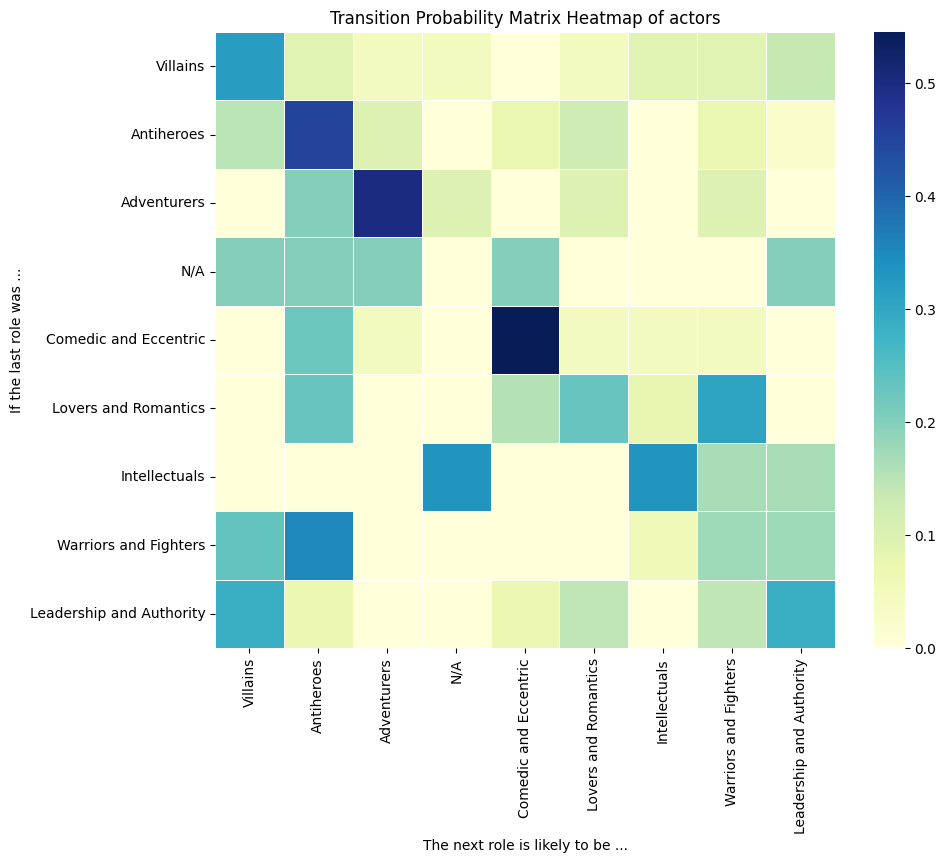

In [9]:
#Plot the transition matrix
plt.figure(figsize=(10, 8))

# Create the heatmap without annotations for the first row
sns.heatmap(transition_matrix, cmap="YlGnBu", annot=False, cbar=True, linewidths=0.5)

# Set axis labels and plot title
plt.xlabel("The next role is likely to be ...")
plt.ylabel("If the last role was ...")
plt.title("Transition Probability Matrix Heatmap of actors")

# Display the heatmap
plt.show()

### Then we will study the age of actors in Romance movies to know when it's recommended to start a creer in this movie industry and when to stop

In [10]:
love_movies = movie_df[movie_df['Movie genres'].str.contains('roman', case=False, na=False)]
movies_sum = love_movies.merge(summary_df, how ='left', on= 'Wiki_movie_id')
movies_sum.dropna(subset=['Summary'],inplace=True)
love_movies = movies_sum[['Wiki_movie_id','Summary']]
love_movies.head()

,Wiki_movie_id,Summary
0,6631279,"Adam, a San Francisco-based artist who works a..."
2,21926710,Jimmy ([[Hiroshi Watanabe loves dinosaurs and...
3,20604092,The film opens with a simpleton from a small v...
4,29528534,"Mary, an orphan lives in an orphanage run by n..."
6,26067101,Perry is an English chemist working for a pain...


In [11]:
# Merge DataFrames based on the 'ID' column
merged_df = pd.merge(love_movies, character_df, on='Wiki_movie_id', how='inner')

#Remove Rows when there is Nan for the character
merged_df.dropna(subset=['Character'],inplace=True)


# Display the resulting DataFrame
merged_df = merged_df[['Wiki_movie_id','Summary','Actor_age','Actor gender','release_date','Character']]
merged_df.drop_duplicates(inplace=True)

#We want to know if we need to perform another analysis on the summary to extract couples
merged_df['Movies_with_same_id'] = merged_df.groupby('Wiki_movie_id')['Wiki_movie_id'].transform('count')

merged_df

,Wiki_movie_id,Summary,Actor_age,Actor gender,release_date,Character,Movies_with_same_id
1,6631279,"Adam, a San Francisco-based artist who works a...",33.0,F,1997.0,Rebecca,2
2,6631279,"Adam, a San Francisco-based artist who works a...",37.0,F,1997.0,Nina,2
18,29528534,"Mary, an orphan lives in an orphanage run by n...",43.0,M,1986.0,Robert Bob,2
19,29528534,"Mary, an orphan lives in an orphanage run by n...",30.0,F,1986.0,Dr. Pramila,2
35,12053509,"Randy Bodek is a rebellious college slacker, ...",40.0,F,1989.0,Diane Bodek,14
...,...,...,...,...,...,...,...
64417,54540,"Akeem Joffer , the prince and heir to the thro...",27.0,M,1988.0,Randy Watson,21
64418,54540,"Akeem Joffer , the prince and heir to the thro...",30.0,M,1988.0,Cab Driver,21
64419,54540,"Akeem Joffer , the prince and heir to the thro...",NaN,M,1988.0,Oha,21
64425,1673588,"Joe Morton stars in this dramatic comedy, set ...",33.0,M,1984.0,Man In Black,2


In [12]:
# Keep only rows where 'Character' is in 'Summary'
df_filtered = merged_df[merged_df.apply(lambda row: row['Character'] in row['Summary'], axis=1)]

df_filtered = df_filtered.drop(columns=['Movies_with_same_id'])
#We want to know if we need to perform another analysis on the summary to extract couples
df_filtered['Movies_with_same_id'] = df_filtered.groupby('Wiki_movie_id')['Wiki_movie_id'].transform('count')

#Only keep when there is only 2 people
# Keep only rows where 'Movies_with_same_id' is equal to 2
df_filtered = df_filtered[df_filtered['Movies_with_same_id'] == 2]

# Display the resulting DataFrame
df_filtered.head()

,Wiki_movie_id,Summary,Actor_age,Actor gender,release_date,Character,Movies_with_same_id
1,6631279,"Adam, a San Francisco-based artist who works a...",33.0,F,1997.0,Rebecca,2
2,6631279,"Adam, a San Francisco-based artist who works a...",37.0,F,1997.0,Nina,2
377,24021571,Leslie Wright is a straight-shooting physical...,38.0,M,2010.0,Scott McKnight,2
378,24021571,Leslie Wright is a straight-shooting physical...,40.0,F,2010.0,Leslie Wright,2
450,9086301,"In every port, sailor Bill, Spencer Tracy, mee...",20.0,F,1931.0,Goldie,2


In [13]:
# Create separate DataFrames for 'F' and 'M' actors
df_F = df_filtered[df_filtered['Actor gender'] == 'F']
df_M = df_filtered[df_filtered['Actor gender'] == 'M']

# Merge DataFrames based on 'wiki_movie_id'
df_merged = pd.merge(df_F, df_M, on='Wiki_movie_id', suffixes=('_F', '_M'))
df_merged = df_merged[['Wiki_movie_id','Actor_age_F','Actor_age_M','release_date_M']]
df_merged

,Wiki_movie_id,Actor_age_F,Actor_age_M,release_date_M
0,24021571,40.0,38.0,2010.0
1,9086301,20.0,31.0,1931.0
2,20694087,19.0,48.0,2009.0
3,5363369,41.0,29.0,1979.0
4,29004995,21.0,24.0,2010.0
...,...,...,...,...
598,28986019,NaN,NaN,2011.0
599,1226363,NaN,NaN,1946.0
600,5667692,46.0,33.0,2002.0
601,8398736,26.0,36.0,2005.0


In [14]:
# Create an empty matrix with dimensions 81x81
matrix_size = 81
age_matrix = np.zeros((matrix_size, matrix_size))

# Iterate over the rows of the DataFrame and increment the corresponding matrix cell
for _, row in df_merged.iterrows():
    if not pd.isna(row['Actor_age_F']) and not pd.isna(row['Actor_age_M']):
        age_matrix[int(row['Actor_age_F']), int(row['Actor_age_M'])] += 1

# Convert the matrix to a DataFrame
age_matrix_df = pd.DataFrame(age_matrix, index=range(matrix_size), columns=range(matrix_size))

# Print or use age_matrix_df as needed
age_matrix_df

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: title={'center': 'Actor Age Heatmap (x-axis for Female and y-axis for Female)'}>

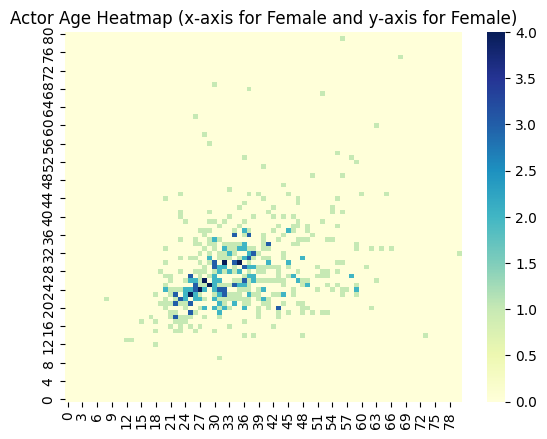

In [15]:
# Sort the index and columns of the heatmap DataFrame
age_matrix_df = age_matrix_df.sort_index(ascending=False)
age_matrix_df = age_matrix_df.sort_index(axis=1)

plt.title('Actor Age Heatmap (x-axis for Female and y-axis for Female)')
plt.ylabel('Actor Age (Male)')
plt.xlabel('Actor Age (Female)')
sns.heatmap(age_matrix_df, annot=False,cmap='YlGnBu')

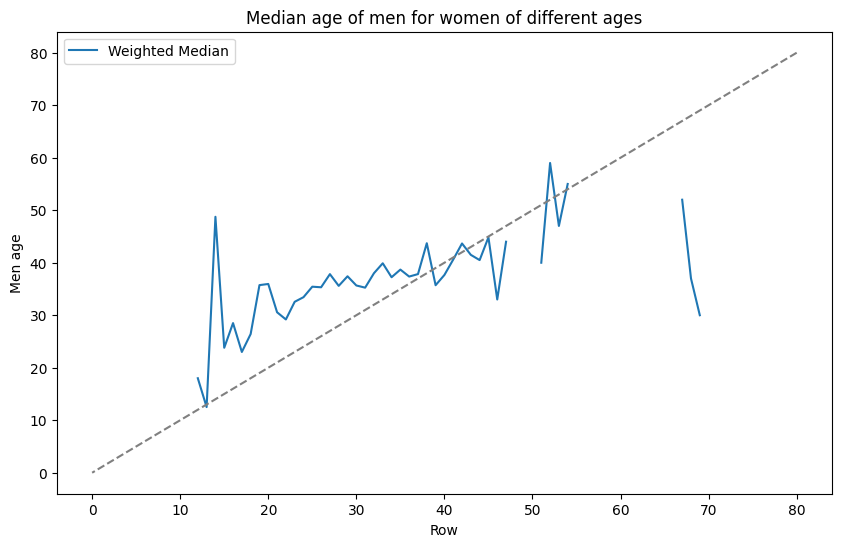

In [16]:
# Calculate the weighted median with a check for zero weights
weighted_median_per_row = age_matrix_df.apply(lambda row: np.average(age_matrix_df.columns.astype(int), weights=row) if row.sum() != 0 else np.nan, axis=1)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(age_matrix_df.index, weighted_median_per_row, label='Weighted Median')

# Add labels and title
plt.xlabel('Row')
plt.ylabel('Men age')
plt.title('Median age of men for women of different ages')
plt.legend()

plt.plot(age_matrix_df.index, age_matrix_df.index, label='Identity', linestyle='--', color='gray')
# Show the plot
plt.show()

In [17]:
df_merged['Age_Difference'] =df_merged['Actor_age_M'] - df_merged['Actor_age_F']
df_merged.head()

,Wiki_movie_id,Actor_age_F,Actor_age_M,release_date_M,Age_Difference
0,24021571,40.0,38.0,2010.0,-2.0
1,9086301,20.0,31.0,1931.0,11.0
2,20694087,19.0,48.0,2009.0,29.0
3,5363369,41.0,29.0,1979.0,-12.0
4,29004995,21.0,24.0,2010.0,3.0


In [18]:
df_merged['Age_Difference'].describe()

count    517.000000
mean       7.129594
std       11.473623
min      -39.000000
25%        1.000000
50%        6.000000
75%       13.000000
max       59.000000
Name: Age_Difference, dtype: float64

In [19]:
df_merged['Actor_age_F'].describe()

count    555.000000
mean      28.246847
std        8.801787
min        9.000000
25%       23.000000
50%       26.000000
75%       32.000000
max       79.000000
Name: Actor_age_F, dtype: float64

In [20]:
df_merged['Actor_age_M'].describe()

count    540.000000
mean      35.279630
std       10.623492
min        8.000000
25%       27.750000
50%       34.000000
75%       41.000000
max       80.000000
Name: Actor_age_M, dtype: float64

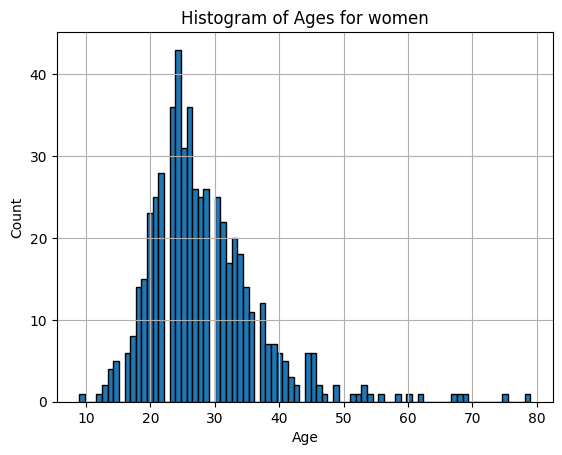

In [21]:
# Remove NaN values and create histogram
df_merged['Actor_age_F'].dropna().hist(bins=80, edgecolor='black')  

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages for women')

plt.show()

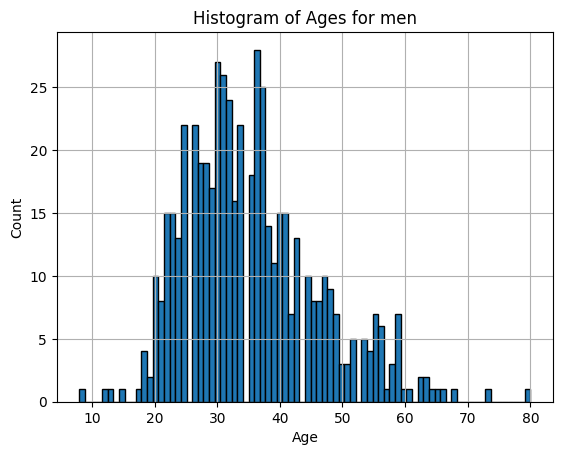

In [22]:
# Remove NaN values and create histogram
df_merged['Actor_age_M'].dropna().hist(bins=80, edgecolor='black')  # Adjust the number of bins as needed

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages for men')

plt.show()